**How do student’s number of school absences and failures affect the final grade?**

Portugal’s education is at the tail end of Europe’s educational level due to student failure and dropout rates (Cortez and Silvia, 2008). 
In 2006 Portugal's early school dropout rate was 40% for 18-24 year olds while the EU average was 15% (Cortez and Silvia, 2008). 
Particularly in Math core classes, which are built upon in later courses, failure rates were high (Cortez and Silvia, 2008). 

The data set that is going to be used is called Student Performance Data Set and  is provided by the University of Minho. It records 33 attributes (binary, nominal and numeric) such as gender, age, parents’ educational levels and occupations, the time students spend traveling to school, and personal time, among other factors that may affect students’ grades (Cortez and Silvia, 2008). 

Most factors were numeric and ranked from 1 to 5. 
For example, health was ranked from 1 - very bad - to 5 - very good. Other factors like weekend/weekday alcohol consumption and some time based attributes (free time after school, going out with friends, etc) were ranked from 1 - very low - to 5 - very high. Travel time from home to school was ranked from 1 - 4. 1 being < 15 min, 2 being 15 to 30 min, 3 being 30 min to 1 hour and 4 being > 1 hour. Weekly study time was also ranked similarly from 1 - 4. 1 being <2 hours, 2 being 2 to 5 hours, 3 being 5 to 10 hours, and 4 being > 10 hours. Grades are numeric on a scale of 1 - 20, but will be converted to letter grades (A to F). Mother's and Father's education is ranked from 0 - 4, with 0 being none, 1 - primary education (up to 4th grade), 2 being 5-9th grade, 3 being secondary education, 4 being post-secondary or above.

We initially were going to use the student's mother and father's level of education, study time, travel time, health condition, number of absences, and number of failures as factors in predicting their final grade. These factors made sense to us as mother's and father's level of education may have a large impact on a student's educational goal and therefore how hard they work towards it. The other factors all relates to time available for studying since if a student has a long distance to travel to school, is in poor health and will miss school, this may reduce their final grade.

As we explore the data set, those ideas will change.


In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 10, repr.plot.height = 10) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Methods**

Firstly, data frame is loaded from the original web source:

In [3]:
# Read the zip file from url and unzip so it can be loaded into a dataframe
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
zip_file <- tempfile(fileext = ".zip")
download.file(url, zip_file, mode = "wb")
student_data <- read_delim(unz(description = zip_file, filename = "student-mat.csv"), delim = ";")

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



Due to the fact that the final grades in the data set are distributed from 0 to 20, they are grouped according to Erasmus, a grade conversion for European students. Grades 0-9 are a ‘fail’, 10-11 are ‘sufficient’, 12-13 are ‘satisfactory’, 14-15 are ‘good’, and 16-20 are ‘excellent’. 

In [4]:
# Grouped the Final Grade into intervals for easier labelling down the line
# Grades 0-5 is 1, 6-10 is 2, 11-15 is 3 and 16-20 is 4

student_data_group <- student_data %>%
    mutate(label = cut(G3, c(0, 9, 11, 13, 15, 20), 
                       #labels = c("fail", "sufficient", "satisfactory", "good", "excellent"), 
                       labels = c(1, 2, 3, 4, 5),
                       left = FALSE)) %>%
    group_by(label = as.factor(label)) %>%
    filter(!is.na(label))

head(student_data_group)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,3,4,1,1,3,6,5,6,6,1
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,3,3,1,1,3,4,5,5,6,1
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,3,2,2,3,3,10,7,8,10,2
GP,F,15,U,GT3,T,4,2,health,services,⋯,2,2,1,1,5,2,15,14,15,4
GP,F,16,U,GT3,T,3,3,other,other,⋯,3,2,1,2,5,4,6,10,10,2
GP,M,16,U,LE3,T,4,3,services,other,⋯,4,2,1,2,5,10,15,15,15,4


Binary and nominal are removed as we were informed that initially they would not make suitable factors in KNN classification.

Binary data is removed as we were informed that they would not make suitable factors for KNN classification. Nominal data is removed as well due to difficulty in providing a scalable measure.


In [5]:
student_data_group_no_bin <- student_data_group %>%
    select(Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3, label)

head(student_data_group_no_bin)

Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,1
1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,1
1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,2
4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,4
3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,2
4,3,1,2,0,5,4,2,1,2,5,10,15,15,15,4


Due to the dataset being small (n = 268), we will allocate a large portion for our training set. Since we are limited by the small size of our data set, we must allocate more into the training set so that we can produce a better predictive model. We also want to balance the amount in our testing set otherwise it may not be representative of the overall set. As such, we have selected to use 75% for our training set and 25% for our testing set.

In [6]:
# Split the data into training and testing set
#student_data_split <- initial_split(student_data_cleaned_binary, prop = 0.75, strata = label)
set.seed(2021)
student_data_split <- initial_split(student_data_group_no_bin, prop = 0.75, strata = label)
student_train <- training(student_data_split)
student_test <- testing(student_data_split)


Preliminary data analysis to look at where the largest counts or average lies for certain factors.

In [7]:
# Exploratory Data Analysis
# Distribution of mother's education level
student_train_meduc <- group_by(student_train, Medu) %>%
    summarize(n = n()) 

# Distribution of father's education level
student_train_feduc <- group_by(student_train, Fedu) %>%
    summarize(n = n())

# Counts number of student failures
student_train_failure <- group_by(student_train, failures) %>%
    summarize(n=n())

# Counts number of student absences
student_train_absences <- group_by(student_train, absences) %>%
    summarize(n=n())

# Computes mean of student absences, family relationship quality, overall health status, travel time
student_train_mean <- group_by(student_train) %>%
    summarize(absences = mean(absences), 
              famrel = mean(famrel),
             health = mean(health),
             traveltime = mean(traveltime),
             studytime = mean(studytime),
             freetime = mean(freetime),
             goout = mean(goout),
             Dalc = mean(Dalc),
             Walc = mean(Walc))


# Student final grade distribution
student_train_G3 <- group_by(student_train, G3) %>%
    summarize(n = n())

student_train_meduc
student_train_feduc
student_train_failure
head(student_train_absences)
student_train_mean

head(student_train_G3)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Medu,n
<dbl>,<int>
0,3
1,35
2,65
3,66
4,100


Fedu,n
<dbl>,<int>
0,1
1,55
2,70
3,78
4,65


failures,n
<dbl>,<int>
0,222
1,34
2,8
3,5


absences,n
<dbl>,<int>
0,61
1,3
2,49
3,6
4,41
5,4


absences,famrel,health,traveltime,studytime,freetime,goout,Dalc,Walc
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.137546,3.94052,3.587361,1.442379,2.074349,3.200743,3.05948,1.460967,2.315985


G3,n
<dbl>,<int>
4,1
5,4
6,12
7,7
8,25
9,20


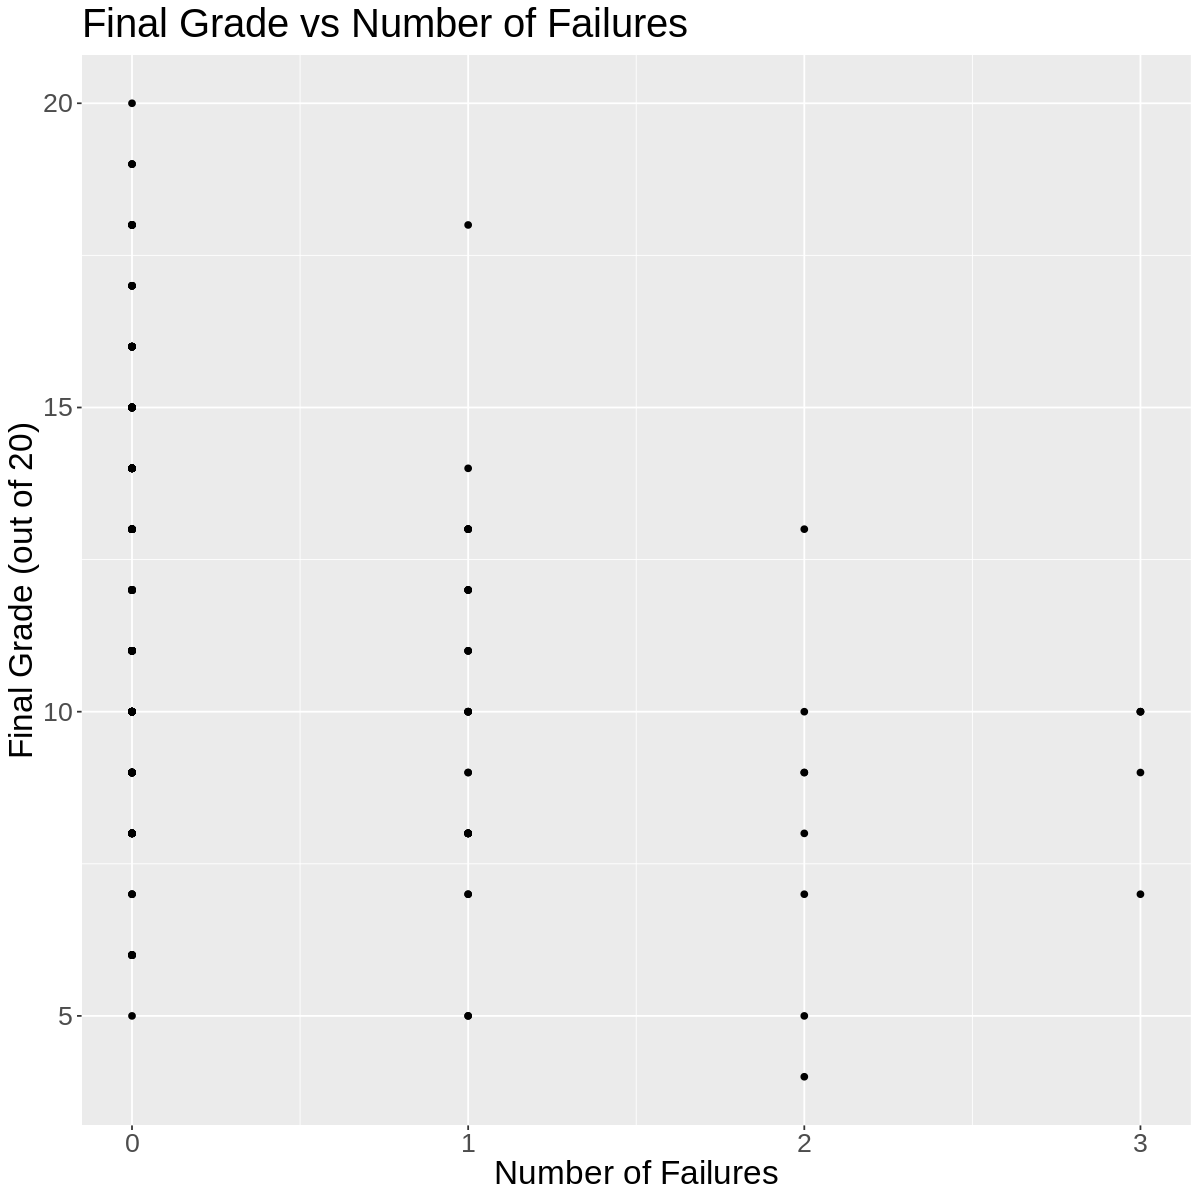

In [8]:
# Exploratory plot of Final Grade vs Number of Failures
student_plot <- ggplot(student_train, aes(x = failures, y = G3)) +
    geom_point() +
    labs(x = "Number of Failures" , y = "Final Grade (out of 20)") +
    ggtitle("Figure 1") +
    theme(text = element_text(size = 20)) +
    ggtitle("Final Grade vs Number of Failures")
student_plot

From this graph, we see a general trend that those who fail more classes tend to have a lower final grade. It is also important to see that even those that with low to no failures have a wide range of final grades.

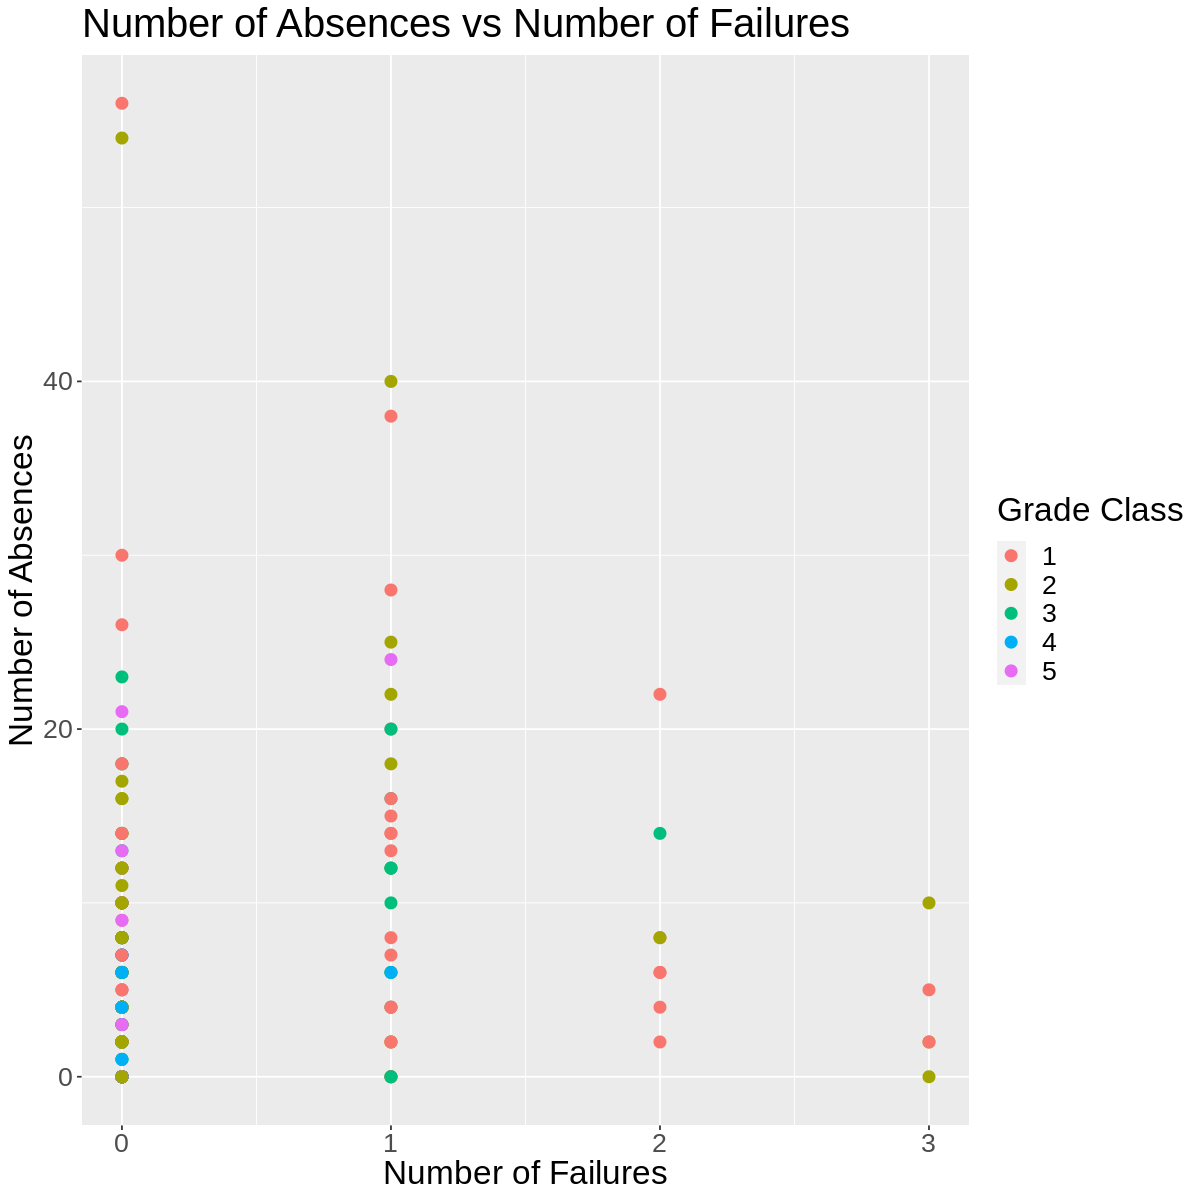

In [9]:
# Exporatory plot of Number of Absences vs Number of Failure with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = failures, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Number of Failures" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    ggtitle("Figure 2") +
    theme(text = element_text(size = 20)) +
    ggtitle("Number of Absences vs Number of Failures")
student_plot2

One might expect a different distribution of data points on this graph, where there are more data points towards the top right of the graph, meaning that those with a high number of absences would also tend to fail more classes. An important note here is that students who score a high grade both have low number of failures (0 - 1) and low number of absences (< 20).

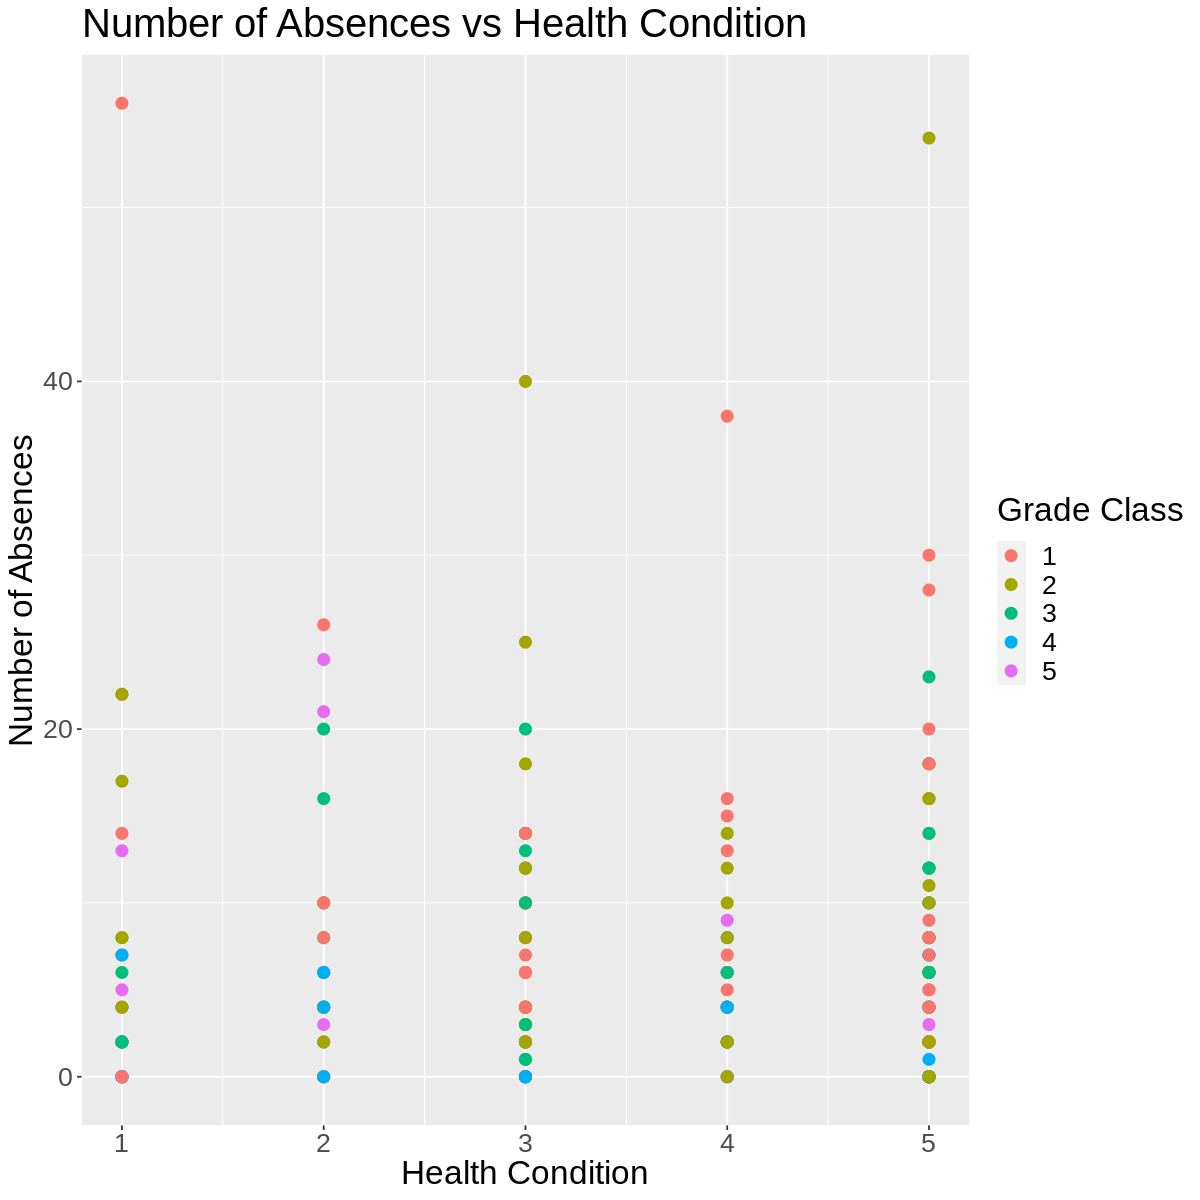

In [10]:
# Exporatory plot of Number of Absences vs Health with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = health, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Health Condition" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    ggtitle("Figure 3") +
    theme(text = element_text(size = 20)) +
    ggtitle("Number of Absences vs Health Condition")
student_plot2

We can see that students with high grades will have low number of absences regardless of their health condition. At the same time, students, regardless of their health condition, will have a low grade if they have a higher number of absences. This may suggest that health does not play a large role in predicting their grade, but absences do.

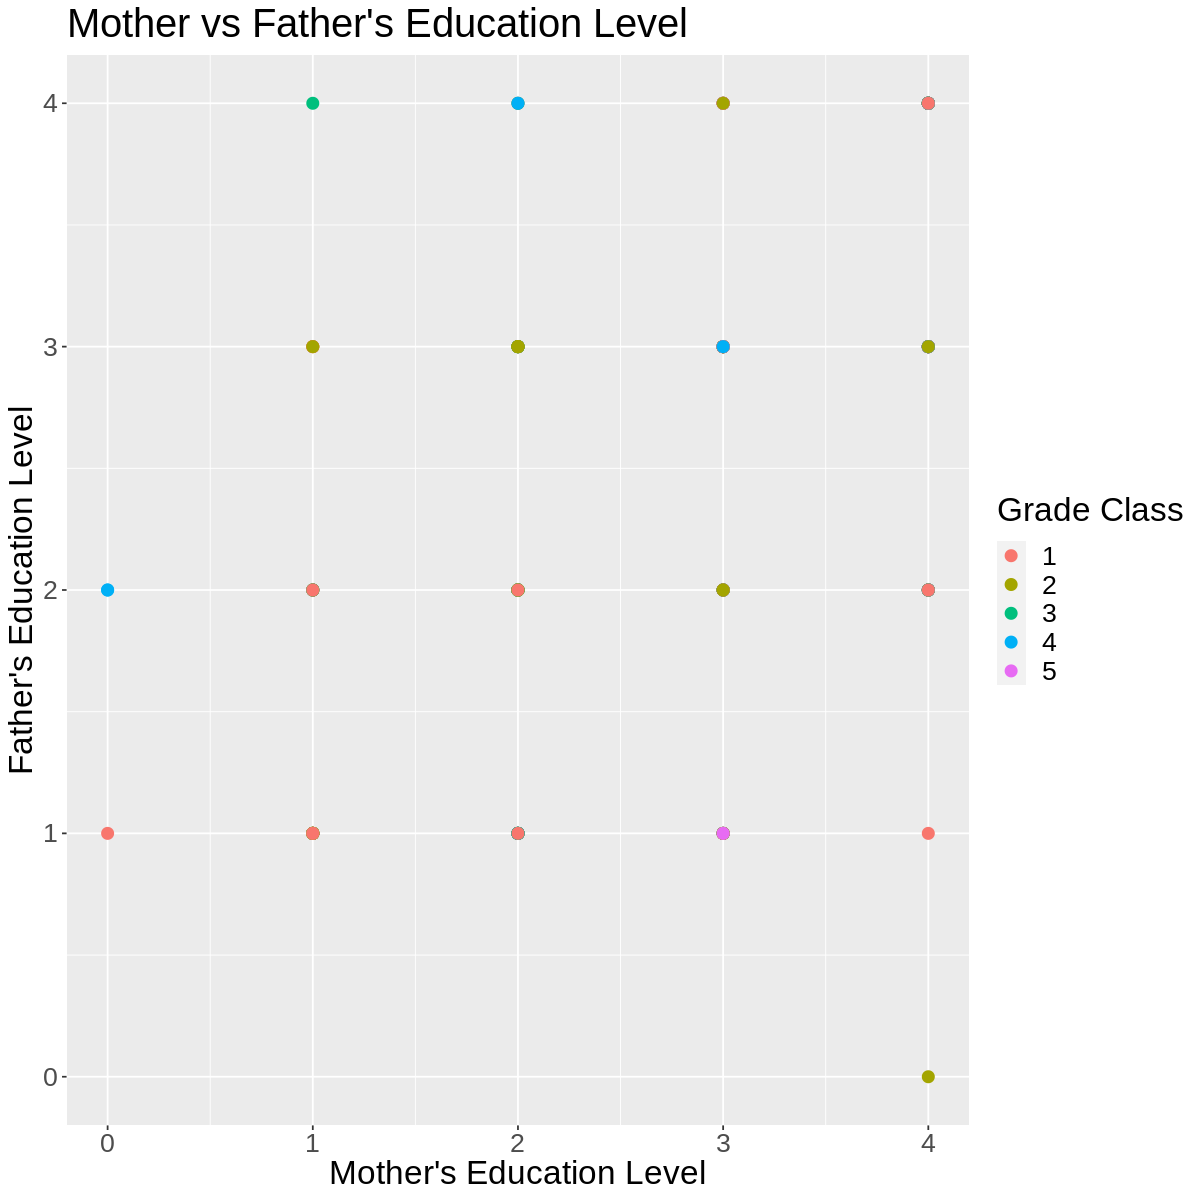

In [11]:
# Exporatory plot of Mother's vs Father's Education Level with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = Medu, y = Fedu, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Mother's Education Level" , y = "Father's Education Level", fill = "Grade Class", color = "Grade Class") +
    ggtitle("Figure 4") +
    theme(text = element_text(size = 20)) +
    ggtitle("Mother vs Father's Education Level")

student_plot2

Initially, we thought that Mother and Father's education level would play a role in students' final grades as it may be expected that children of highly educated parents also strive for higher education and therefore achieve higher grades. From this plot, it appears that the mother's education level plays a larger role in determining the grades. Perhaps we should look into more specifically each parent's effect on grade.

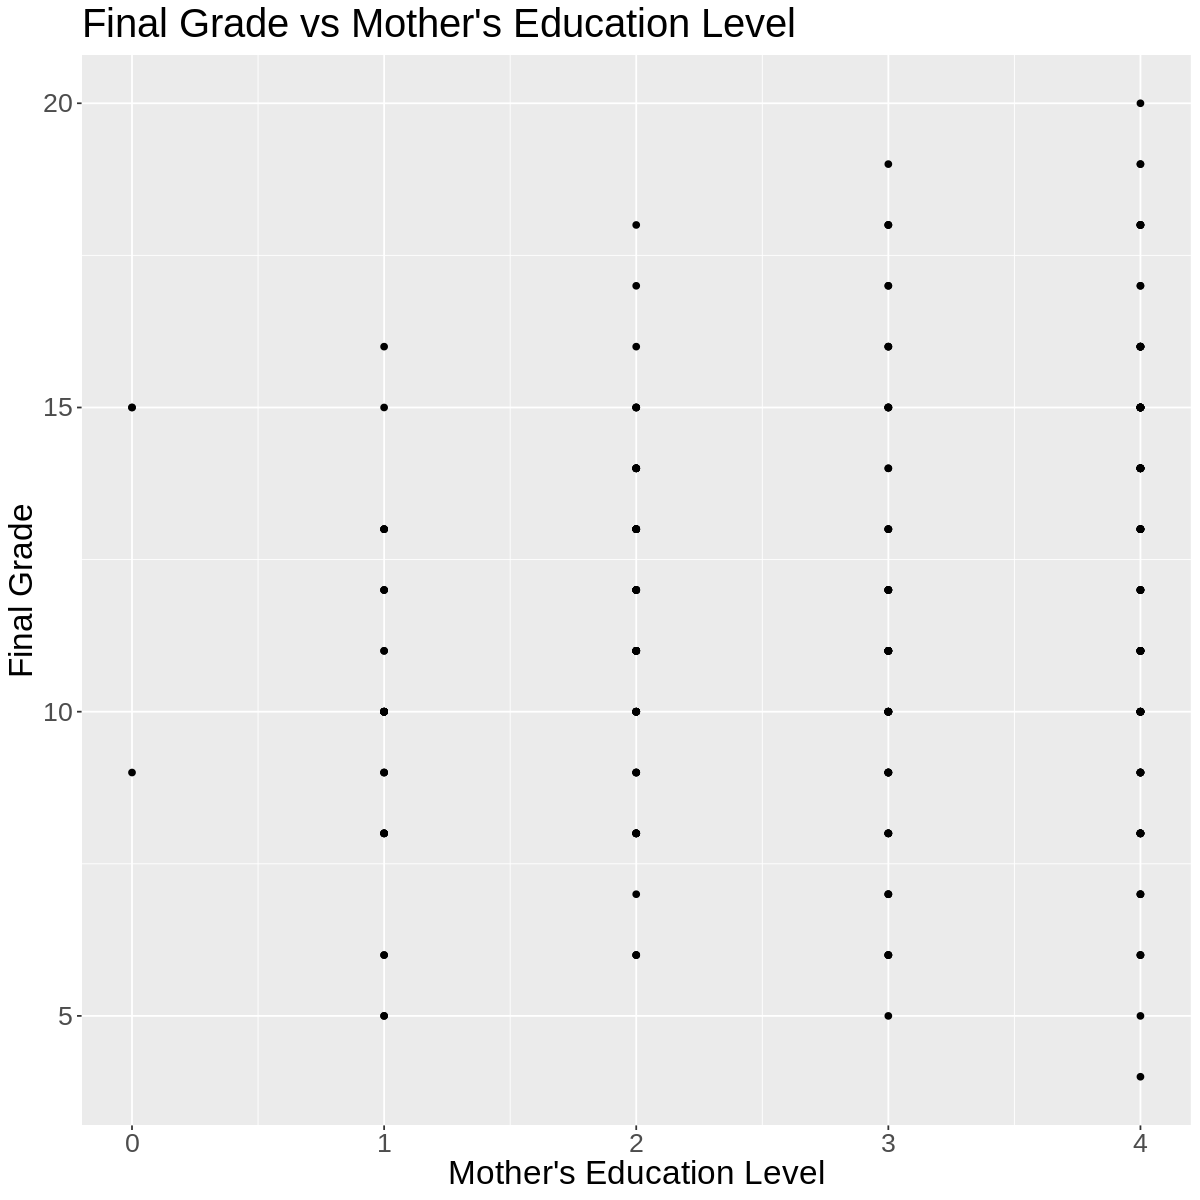

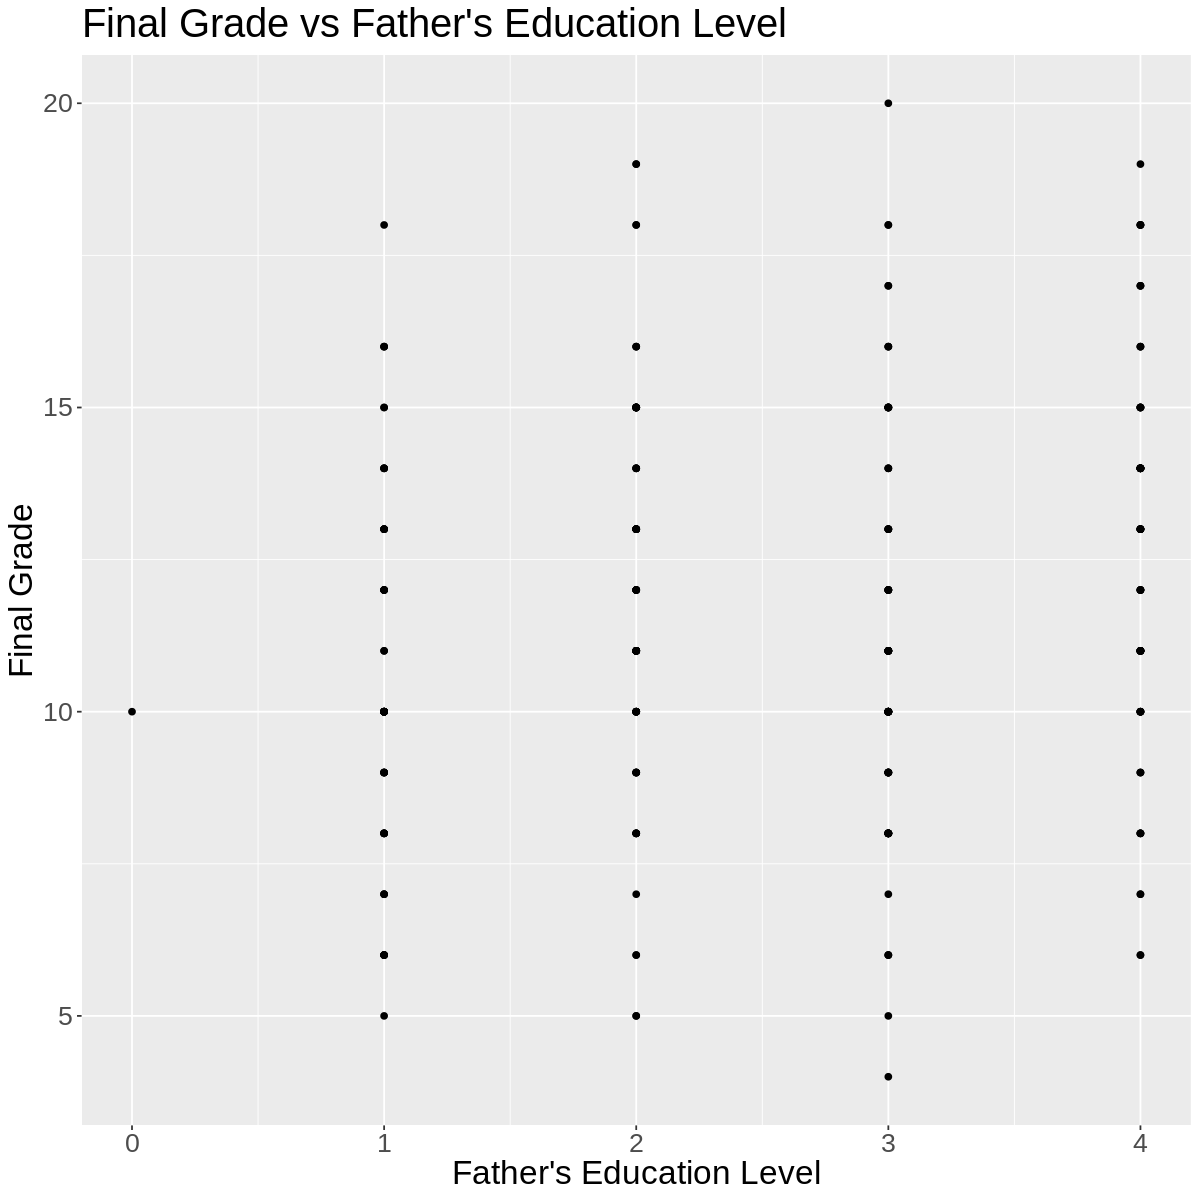

In [12]:
student_plot132 <- ggplot(student_train, aes(x = Medu, y = G3)) + 
    geom_point() + 
    labs(x = "Mother's Education Level" , y = "Final Grade") + 
    theme(text = element_text(size = 20)) +
    ggtitle("Final Grade vs Mother's Education Level")
student_plot132

student_plot133 <- ggplot(student_train, aes(x = Fedu, y = G3)) + 
    geom_point() + #
    labs(x = "Father's Education Level" , y = "Final Grade") + 
    theme(text = element_text(size = 20)) +
    ggtitle("Final Grade vs Father's Education Level")
student_plot133

Looking at parents who have received at least some education, it does not appear that parents' education level has an effect on a student's final grade. For parents who did not receive any level of education, there is not enough data to draw conclusions.

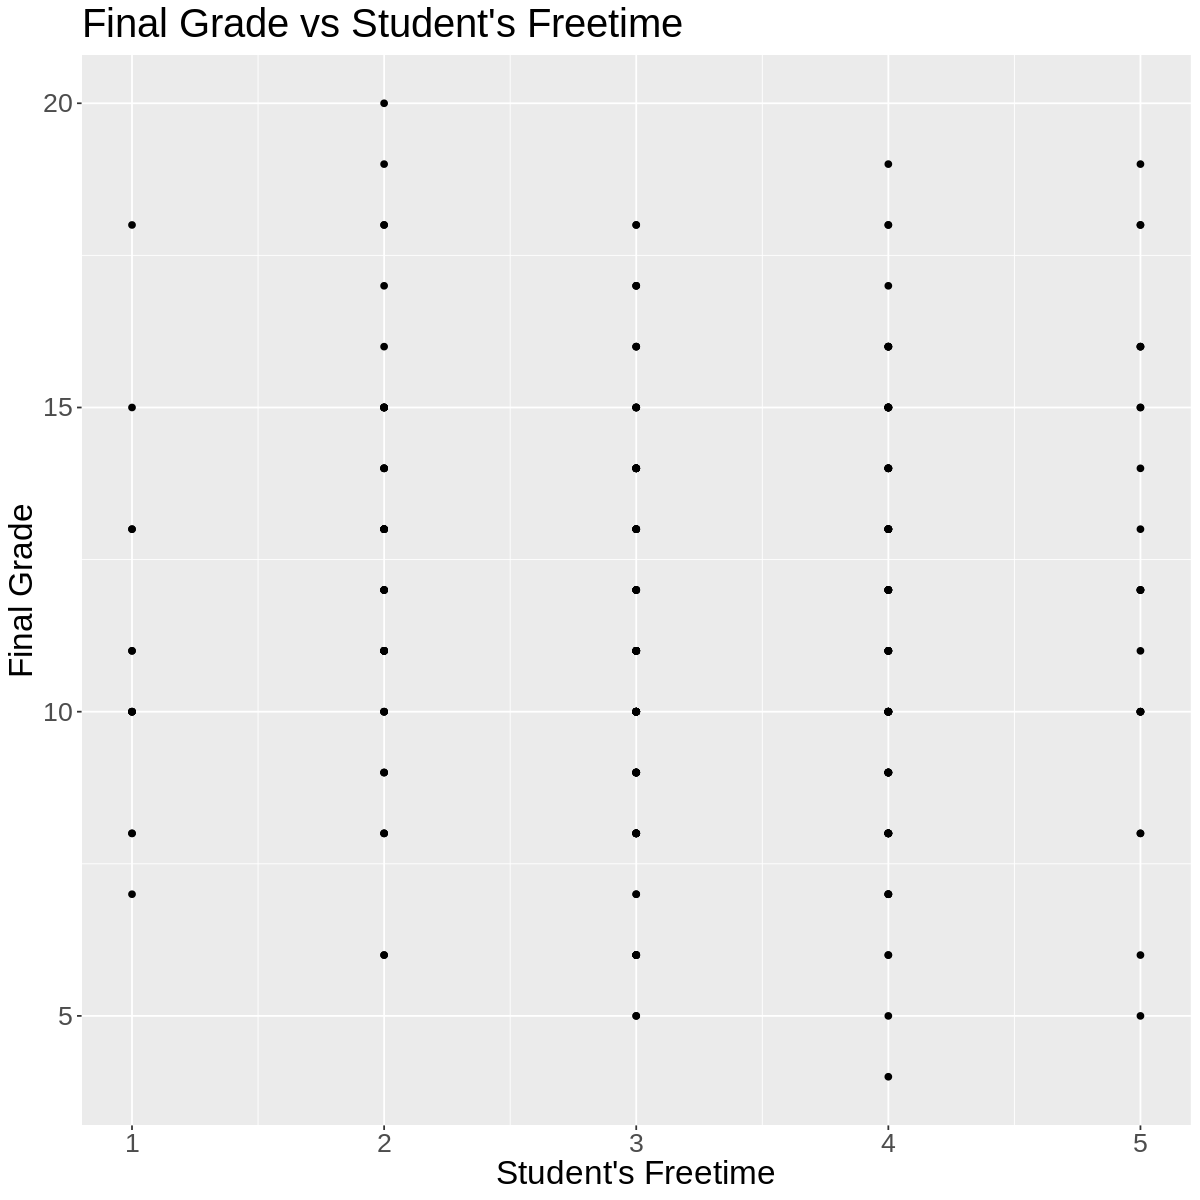

In [13]:
student_plot5 <- ggplot(student_train, aes(x = freetime, y = G3)) + #, fill = label)) +
    geom_point() + #aes(color = label), size = 3, alpha = 0.5) +
    labs(x = "Student's Freetime" , y = "Final Grade") + #, fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20)) +
    ggtitle("Final Grade vs Student's Freetime")
student_plot5

This graph suggests that a student's freetime has little to no effect on their final grade.

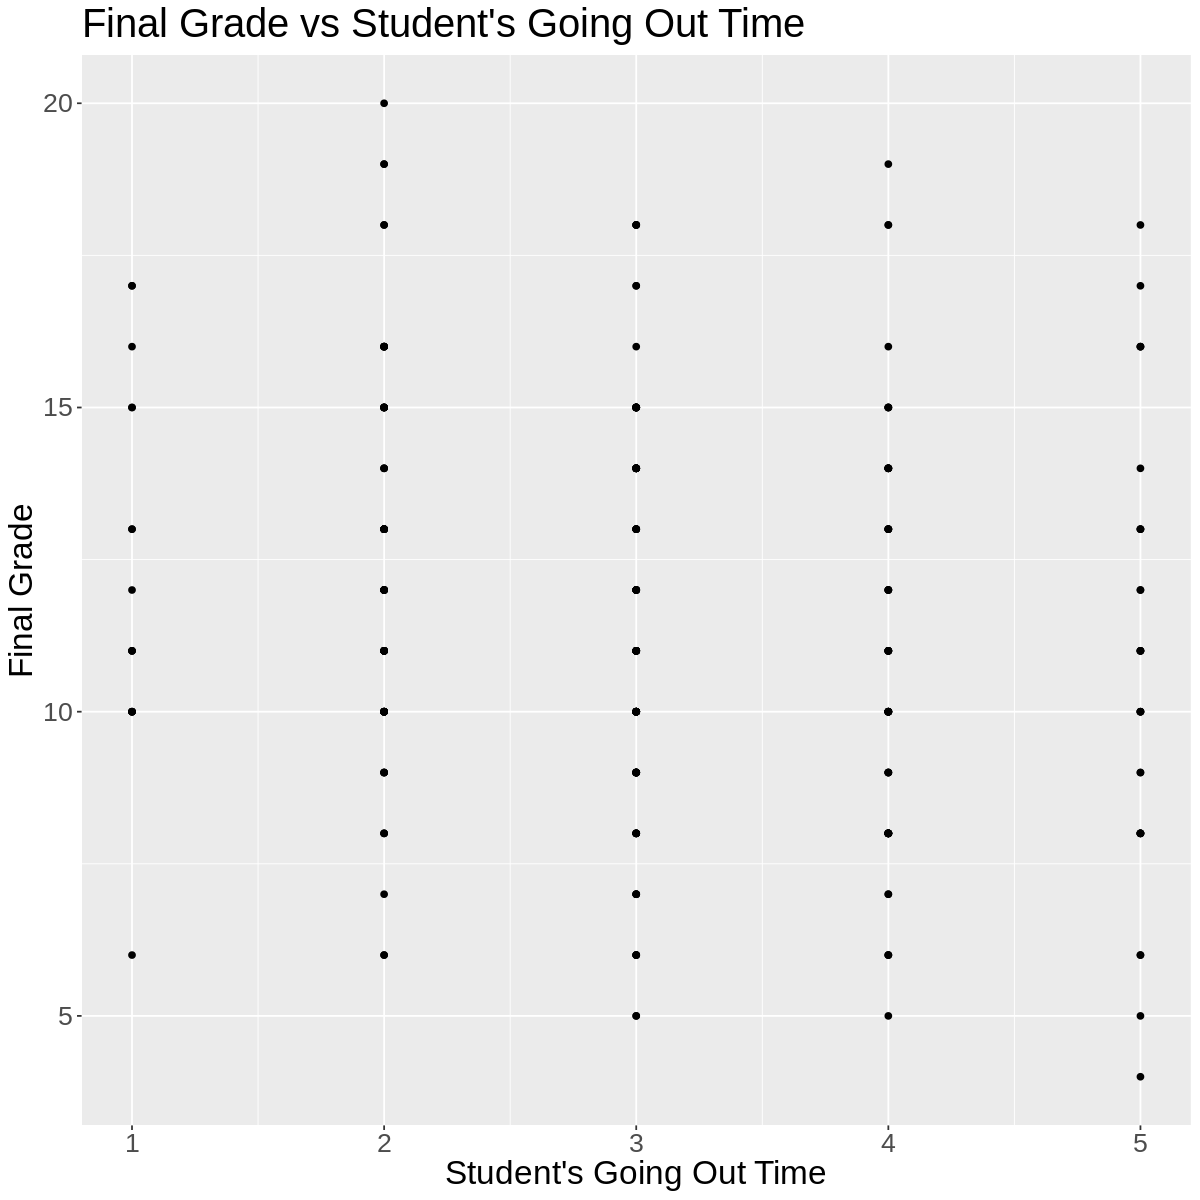

In [14]:
student_plot6 <- ggplot(student_train, aes(x = goout, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Going Out Time" , y = "Final Grade") + 
    theme(text = element_text(size = 20)) +
    ggtitle("Final Grade vs Student's Going Out Time")
student_plot6

This graph suggests that going out more does not have an effect on final grades.

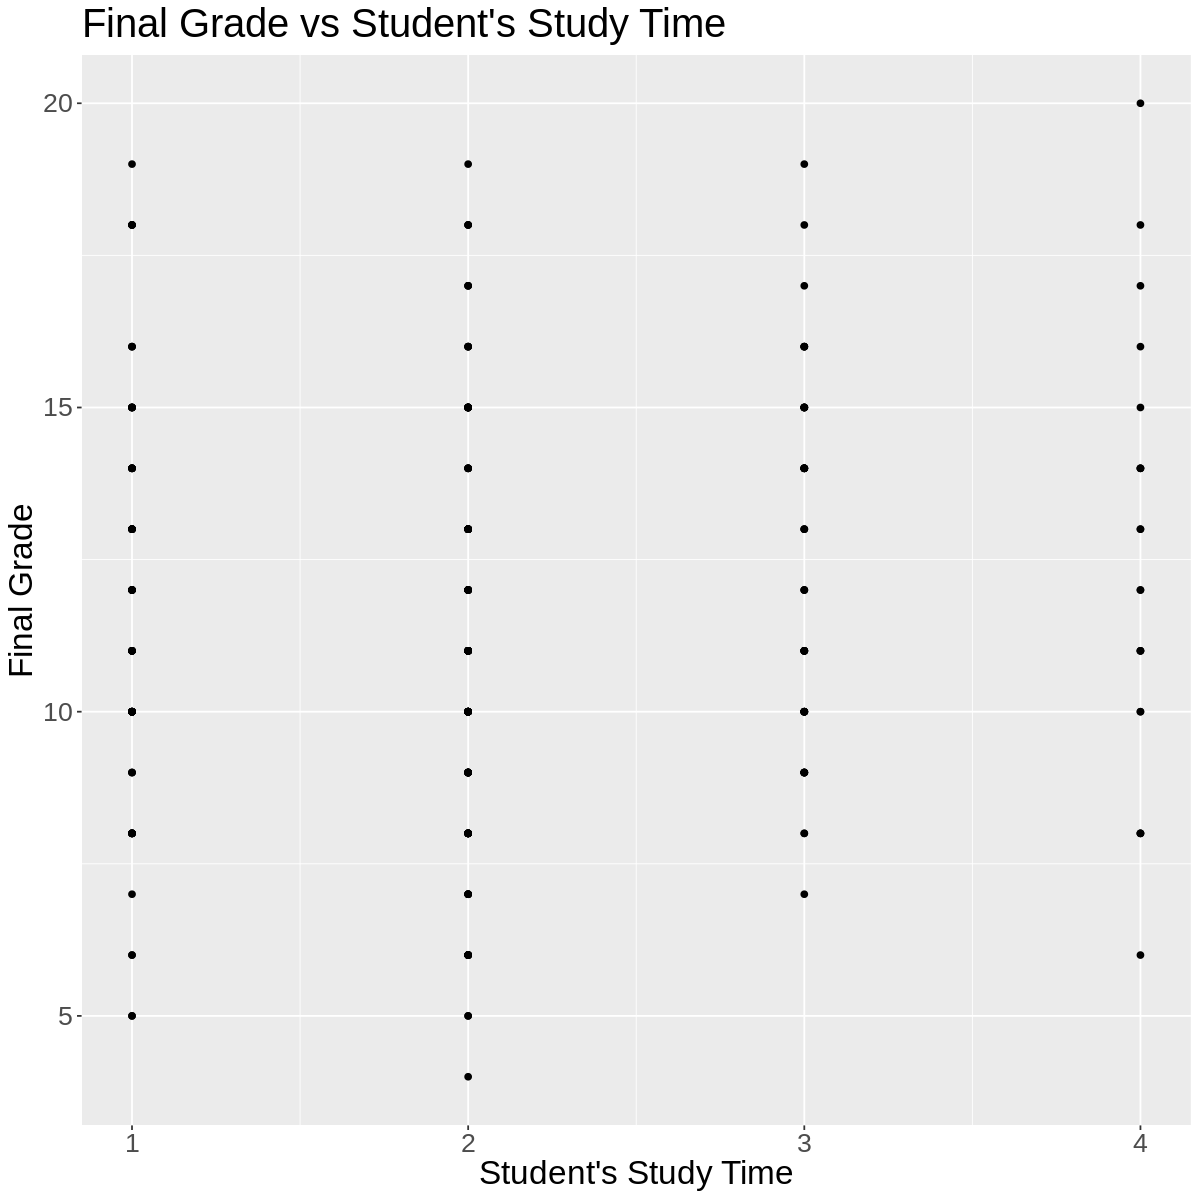

In [15]:
student_plot6 <- ggplot(student_train, aes(x = studytime, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Study Time" , y = "Final Grade") + 
    theme(text = element_text(size = 20)) +
    ggtitle("Final Grade vs Student's Study Time")
student_plot6

Surprisingly, this plot suggests that studying more will not result in a higher final grade. Zooming out, we can see that students that do study more will not achieve extremely low scores unlike their counterparts who studied less.

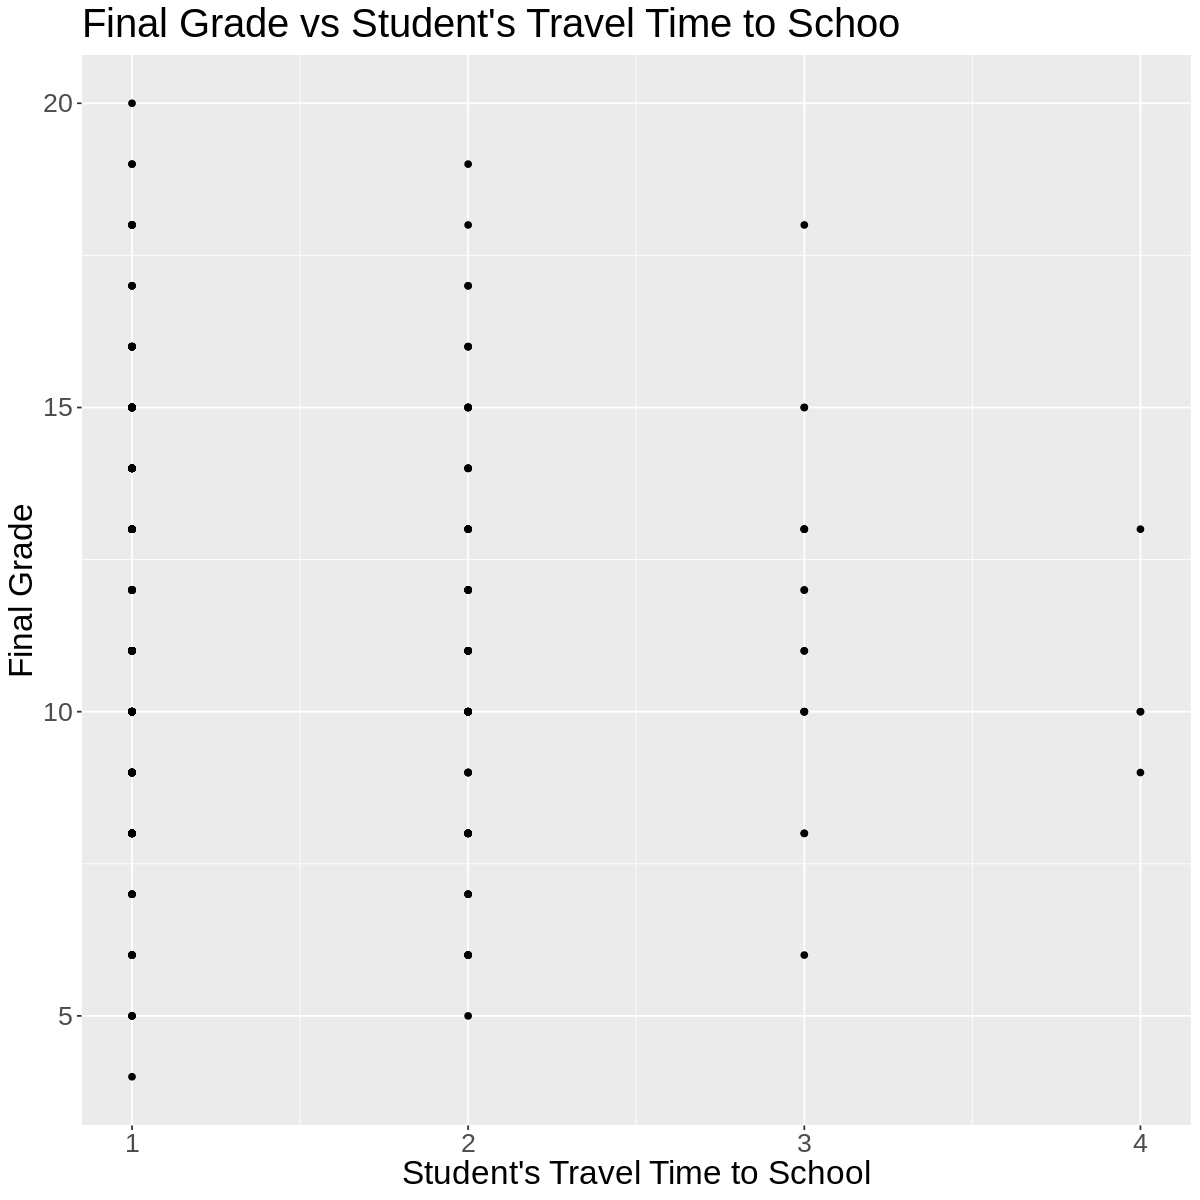

In [16]:
student_plot8 <- ggplot(student_train, aes(x = traveltime, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Travel Time to School" , y = "Final Grade") + 
    theme(text = element_text(size = 20)) +
    ggtitle("Final Grade vs Student's Travel Time to Schoo")
student_plot8

Here we can see that as travel time increases, the grades converge. Compared to students who spent less time traveling, high travellers have a less variable range of grades, with their highest grades being lower than and their lowest grades being higher than those of their peers who travel less often.

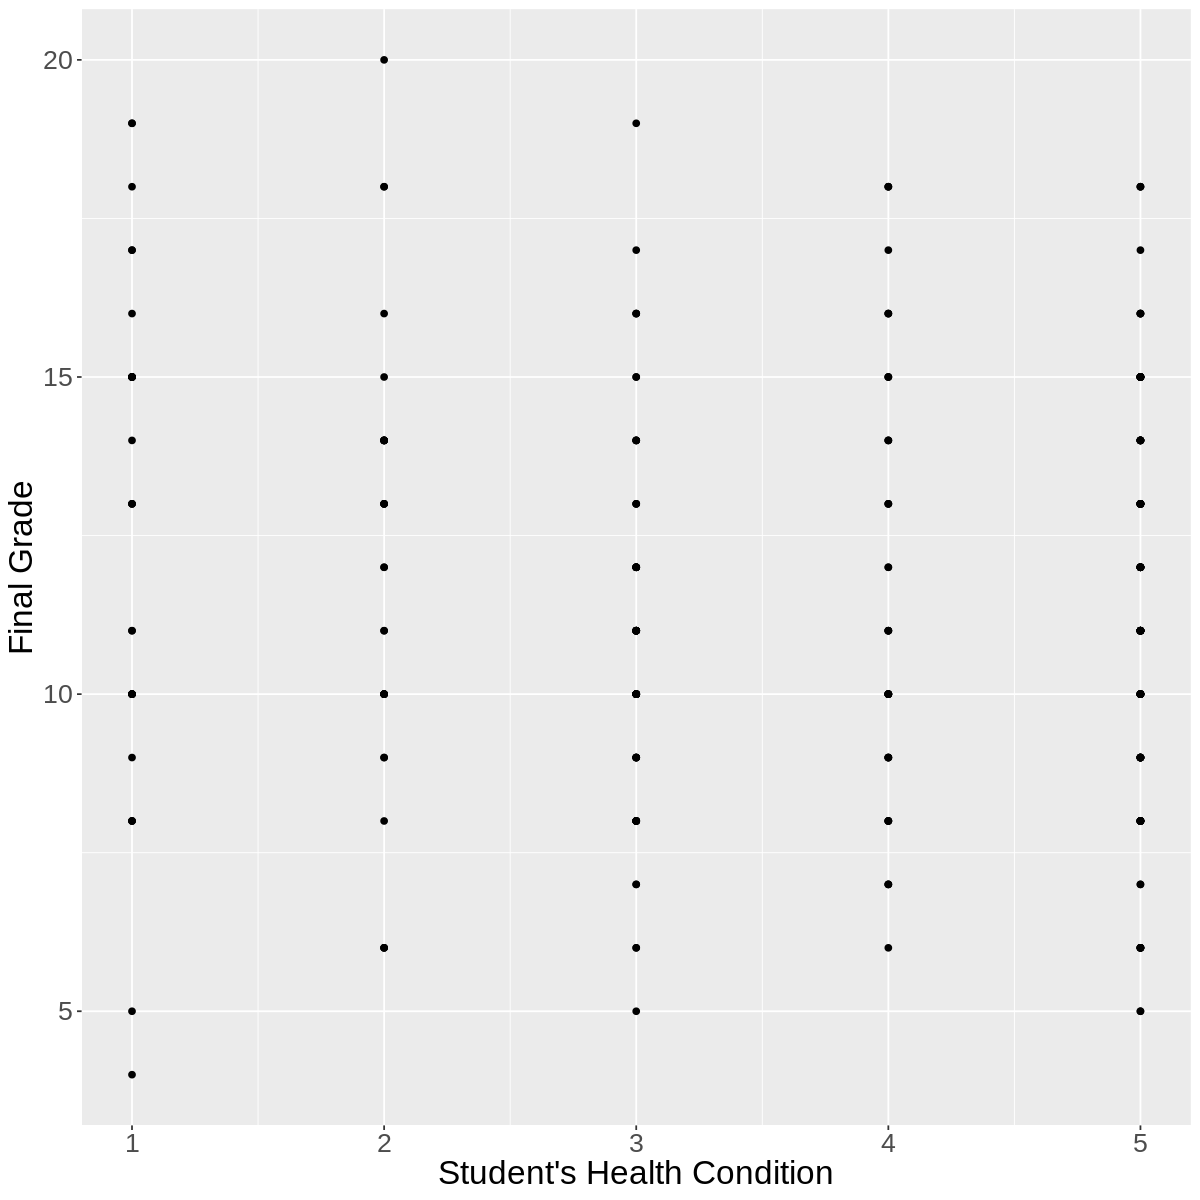

In [17]:
student_plot9 <- ggplot(student_train, aes(x = health, y = G3)) + 
    geom_point() + 
    labs(x = "Student's Health Condition" , y = "Final Grade") + 
    theme(text = element_text(size = 20))
student_plot9

This graph solidifies the suggestion that the student's health condition plays little effect into determining a student's grade.

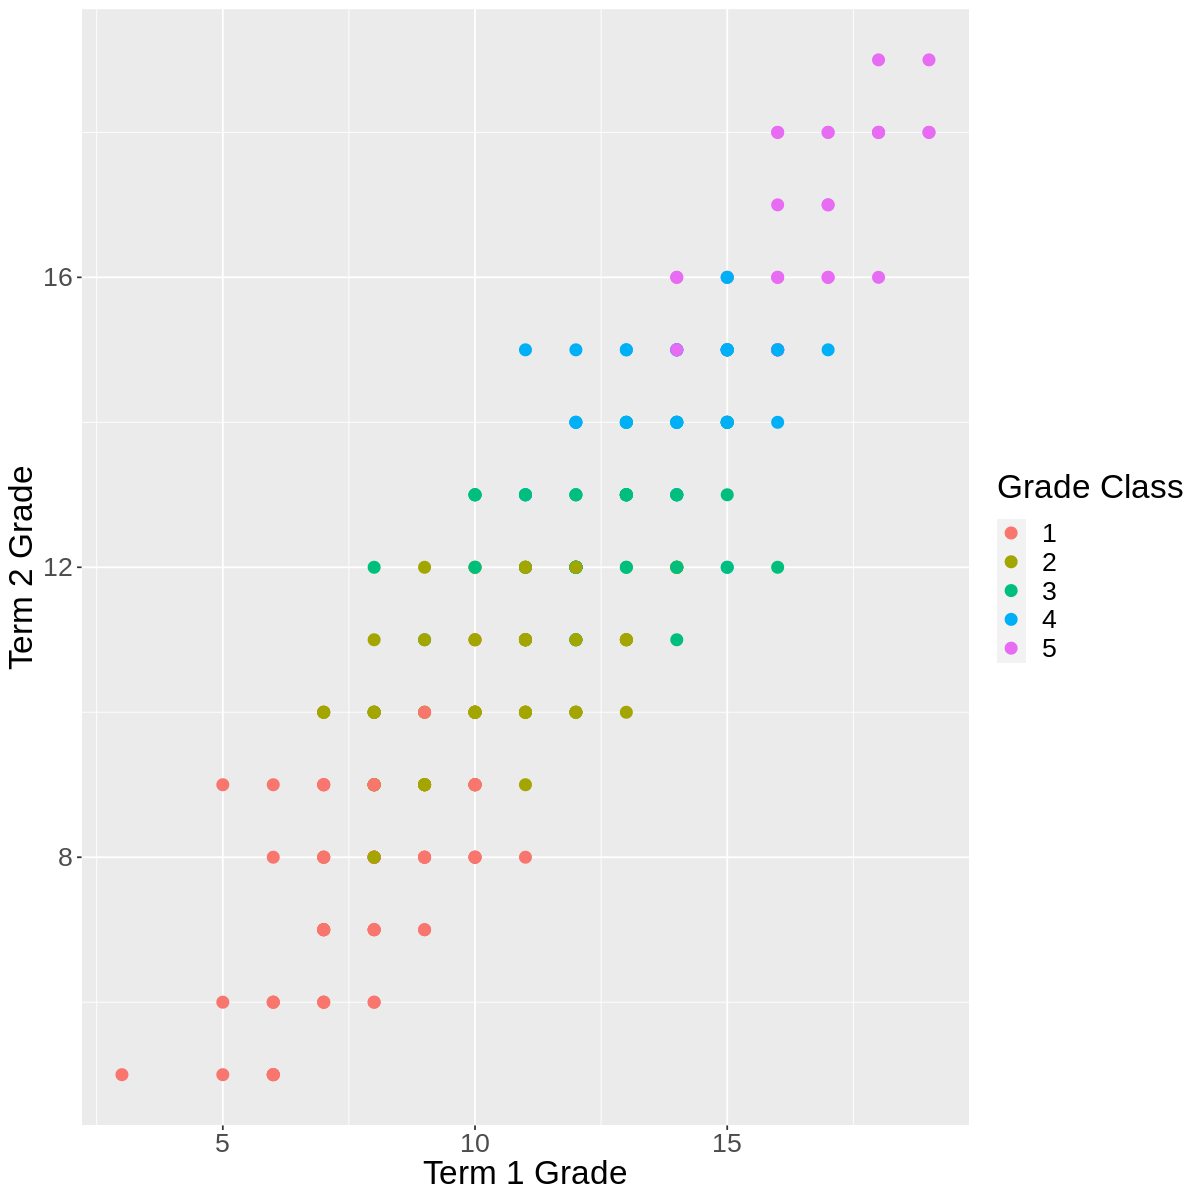

In [18]:
student_plot10 <- ggplot(student_train, aes(x = G1, y = G2, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Term 1 Grade" , y = "Term 2 Grade", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot10

This graph shows that students generally maintain their grades throughout the year. While this may be a useful indicator to use, it provides little insight into WHY students achieve the grades they do.

Of the remaining factors, it appears that the number of absences and number of failures would be the best factors in predicting a student's final grade.

In [19]:
# model specification to produce a baseline accuracy
set.seed(2021)

#failures + absences
student_recipe <- recipe(label ~ failures + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit <- workflow() %>%
     add_recipe(student_recipe) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~7, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.66171
Best kernel: rectangular
Best k: 7

In [20]:
# Apply our model to the testing data set
student_test_pred <- predict(knn_fit, student_test) %>%
    bind_cols(student_test)

# Determine the accuracy and confusion matrix of the prediction
accuracy = student_test_pred %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.29545455
kap,multiclass,0.09594035


          Truth
Prediction  1  2  3  4  5
         1 12  7  4  4  1
         2  5  6  1  3  2
         3  1  0  1  0  0
         4  5 12  9  7  7
         5  0  0  0  1  0

With 5 neighbours we found that the accuracy is only 29.5% and we can definitely do better. We will tune our classifier in order to increase our accuracy.

In [21]:
# cross-validation

set.seed(2021)

student_vfold <- vfold_cv(student_train, v = 10, strata = label)

student_recipe_2 <- recipe(label ~ absences + failures,
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2 <- workflow() %>%
    add_recipe(student_recipe_2) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2 %>% collect_metrics()

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2963036,10,0.01129607
roc_auc,hand_till,0.5506044,10,0.01525038


We see a slight improvement from our previous accuracy $(29.5\%$ to $29.6\%)$. This likely means that the splitting determined by the seed was among the highest accuracy possible.

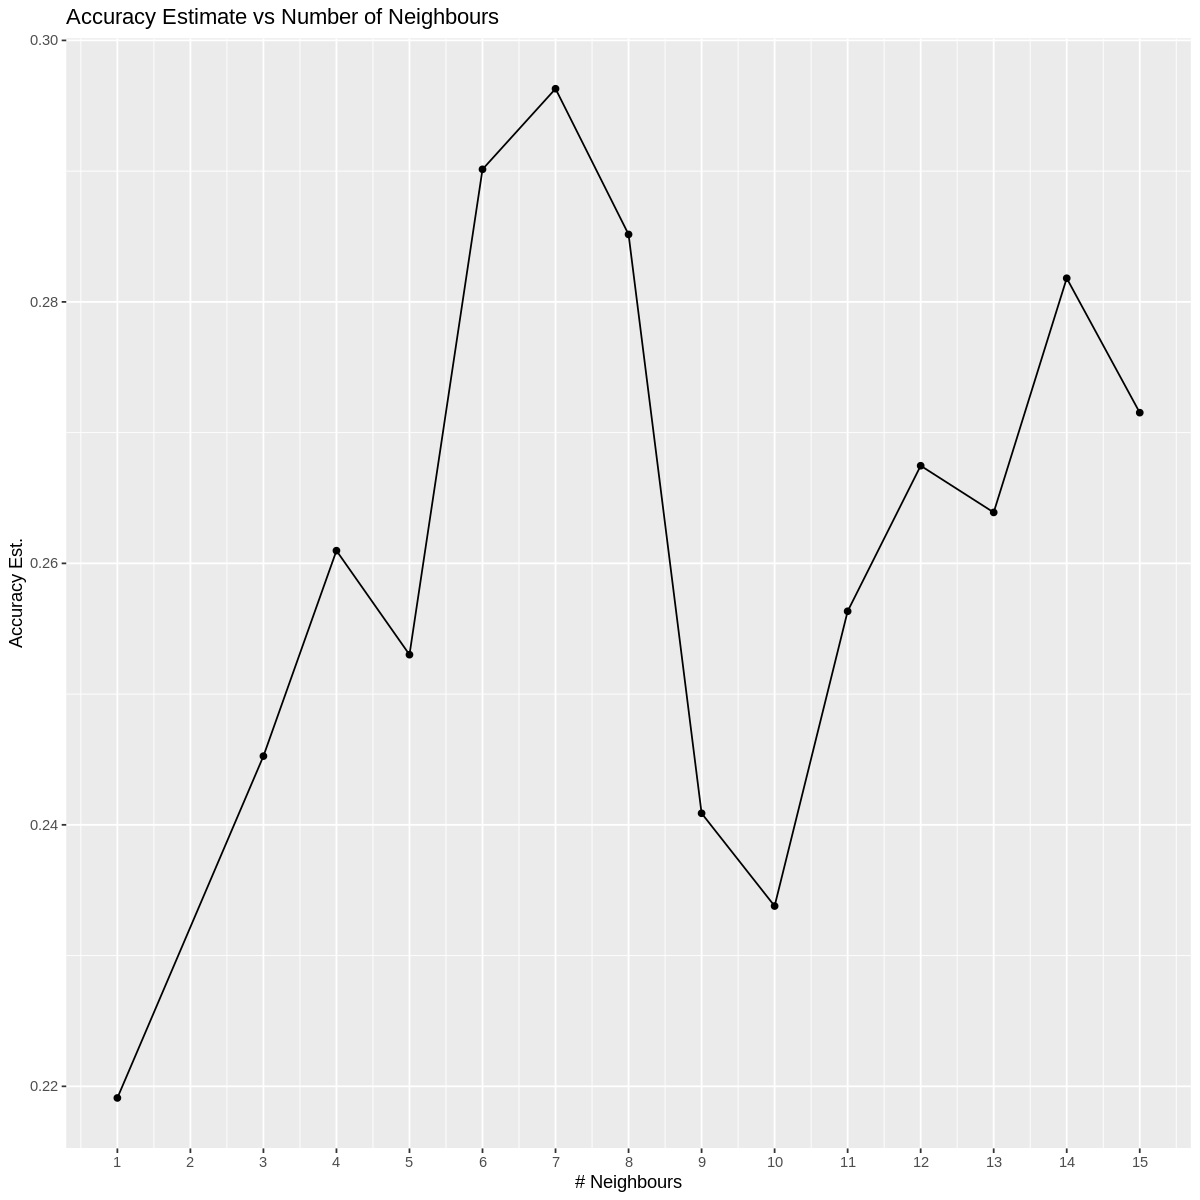

In [22]:
# Finding the best K by plotting accuracy vs K
set.seed(2021)
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")


knn_results_tuned <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()


accuracies <- knn_results_tuned %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "# Neighbours", y = "Accuracy Est.") +
    ggtitle("Accuracy Estimate vs Number of Neighbours") +
    scale_x_continuous(breaks = 1:15)
    
accuracy_vs_k

The visualization suggests that $K =  7$ provides the highest accuracy. We will select $7$ as the number of neighbors because its neighboring values have a similar accuracy value and 7 is not too high of a value so it doesn't take up too much processing power.

Since we already used $K = 7$ to determine our baseline accuracy, we did not include the data analysis again.

**Discussion**

Our research question asks how certain academic predictors affect the final math grade of a university student. We expected to find a significant correlation between a student’s past absences and failures and their final grade. Students with records of more effort were expected to continue those trends. The highest accuracy our model was able to achieve is 29.6% after testing various values of $K$s. This accuracy may indicate that the variables, despite the fact that they had the greatest effect on final grades, do not correlate strongly with final grades.

The low accuracy may also be credited to the data set's choice of predictors. The study includes predictors such as travel time and study time, which have been shown to have a negligible effect on grades (Wu 2014, Plant et al. 2005). However, it also includes health and social factors such as extraversion, which have been shown to have a complex - but large - effect on academic performance (Ding et al. 2009, Pritchard and Wilson 2003). We did not use these factors, but in particular the fact that our preliminary data analysis showed that health and social factors had little effect on final grades could be due to data that does not accurately reflect the real-life situation. These factors were all graded on a numeric scale, which does not allow space to consider their nuance and intersections. The issue of our low accuracy could be ascribed to the researchers' choice of variables, which are not necessarily appropriate for predicting grades, and if they are, may not be presented in a way that accurately includes the details of what is affecting academic performance.

The researchers also note that they were able to predict the final grades with high accuracy if they included Term 1 and Term 2 grades. But in doing so, it would be more difficult to determine what factors have a high impact on final grade since students who achieve high grades throughout the semester are expected to maintain those high grades.

If used correctly, predicting which students are at risk of poor academic performance could be used to offer extra support, either individually or through the academic infrastructure. However, the methods to determine an student at risk of failure may be difficult to perfect. Factors that you may have assumed were relevant, such as study time, could have little to no documented effect. Factors with a large effect, such as health and stress, may also so no effect due to their naturally complex nature, which may make it difficult to condense into a data set.

**References**

Cortez, P. and A. Silva. "Using Data Mining to Predict Secondary School Student Performance." In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

Ding, Weili, et al. "The impact of poor health on academic performance: New evidence using genetic markers." _Journal of Health Economics_
vol. 28, no. 3, May 2009, pp. 578-597. _Science Direct_, https://doi.org/10.1016/j.jhealeco.2008.11.006.

Plant, E. Ashby, et al. "Why study time does not predict grade point average across college students: Implications of deliberate practice for academic performance."_Contemporary Educational Psychology_, vol. 30, no. 1, 2005, pp. 96-116. _Science Direct_, https://doi.org/10.1016/j.cedpsych.2004.06.001.

Pritchard, Mary E and Gregory S. Wilson. "Using Emotional and Social Factors to Predict Student Success." _Journal of College Student Development_, vol. 44, no. 1, January 2003, pp. 18-28.

Wu, Qianying. "Associations Between Travel Behavior and the
Academic Performance of University Students." _All Theses_, 2014. https://tigerprints.clemson.edu/all_theses/2063.